# Swin Unet実装

In [1]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# https://github.com/HuCaoFighting/Swin-Unet/blob/main/networks/swin_transformer_unet_skip_expand_decoder_sys.py

In [3]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super(Mlp, self).__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [4]:
def window_partition(x, window_size):
    """
    Args:
        x:(B, H, W, C)
        window_size (int): window size
    
    Return:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H//window_size,window_size, W//window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H*W/window_size/window_size))
    x = windows.view(B, H//window_size,window_size,W//window_size,window_size, -1)
    x = x.permute(0,1,3,2,4,5).contiguous().view(B, H, W, -1)
    return x


In [5]:
x = torch.rand(size=(16, 256, 256, 3))
windows = window_partition(x, 32)
window_reverse(windows,32,256, 256).shape

torch.Size([16, 256, 256, 3])

In [6]:
image = cv2.imread("../dataset/cat.jpg")
image = cv2.resize(image, (256,256))
image = torch.tensor(image, dtype=torch.float32).view(1, *image.shape)

In [7]:
def tensor2array(x):
    x = x.squeeze().detach().numpy().astype(np.uint8)
    return x

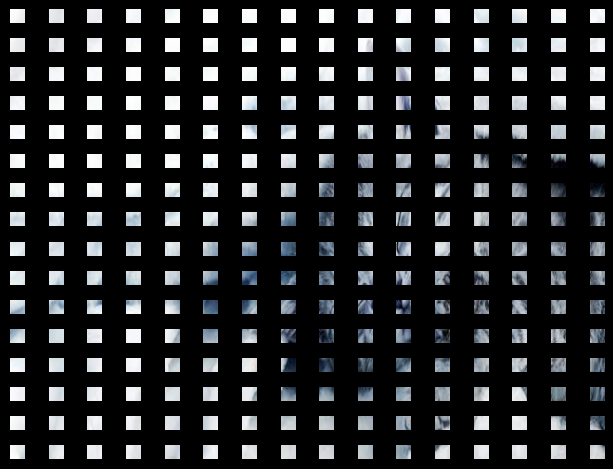

In [8]:
p = 4 
windows = window_partition(image, 2**p)
def plot(x, cmap=None):
    if cmap:
        plt.imshow(tensor2array(x), cmap=cmap)
    else:
        plt.imshow(tensor2array(x))

s = int((256//2**p))
for i in range(1,s**2+1):
    plt.subplot(s,s,i)
    plot(windows[i-1])
    plt.axis("off")
plt.tight_layout()
plt.show()

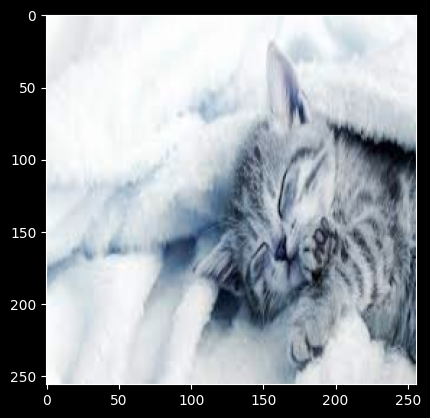

In [9]:
rev_x = window_reverse(windows, 2**p, 256,256)
plot(rev_x)

In [141]:
class WindowAttention(nn.Module):
    """ Window based multi-head self attention
    """
    def __init__(self, dim:int, window_size:tuple[int], num_heads:int, qkv_bias:bool=True, qk_scale:float=None, attn_drop:float=0., proj_drop:float=0.):
        """
        Args:
            dim (int): Number of input channels
            window_size (tuple[int]): The height and width of the window
            num_heads (int): Number of attention heads
            qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
            qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
            attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
            proj_drop (float, optional): Dropout ratio of output. Default: 0.0
        """
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size # Window height, Window width
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # difine a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2*window_size[0]-1)*(2*window_size[1]-1), num_heads) # 2Wh-1, 2Ww-1, num_heads
        )

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij")) # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1) #2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :] # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0) # Wh*Ww, Wh*Ww, 2
        relative_position_index = relative_coords.sum(-1) #Wh*Wh, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x : input features with shape of (num_windows*B, N, C) 
            mask : (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4) #3, B_, num_heads, N, C//num_heads
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2 ,-1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1
            )  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # num_heads, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [142]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        r""" Swin Transformer Block.
        Args:
            dim (int): Number of input channels.
            input_resolution (tuple[int]): Input resulotion.
            num_heads (int): Number of attention heads.
            window_size (int): Window size.
            shift_size (int): Shift size for SW-MSA.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
            qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
            drop (float, optional): Dropout rate. Default: 0.0
            attn_drop (float, optional): Attention dropout rate. Default: 0.0
            drop_path (float, optional): Stochastic depth rate. Default: 0.0
            act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
            norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        """
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(input_resolution) <= window_size:
            self.shift_size = 0
            self.window_size = min(input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim*mlp_ratio)
        self.mlp = Mlp(dim, mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            img_mask = self.make_mask()
        
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size*self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        
        self.register_buffer("attn_mask", attn_mask)
            
    
    def make_mask(self):
        H, W = self.input_resolution
        img_mask = torch.zeros((1, H, W, 1))
        slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None)
            )
        cnt = 0
        for h in slices:
            for w in slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1
        return img_mask
    
    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H*W, "input feature has wrong size"
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        #cyclic shift
        if self.shift_size > 0.:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1,2))
        else:
            shifted_x = x
        
        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size*self.window_size, C)

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # meerge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        # reverse cyclic shift
        if self.shift_size > 0.:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1,2))
        else:
            x = shifted_x
        
        x = x.view(B, H*W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [147]:
class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super(PatchMerging, self).__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)
        self.norm = norm_layer(4*dim)
    
    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H*W, "input feature has wrong size"
        assert H%2 ==0 and W%2==0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1) # B, H/2, W/2, 4*C
        x = x.view(B, -1, 4*C)
        x = self.norm(x)
        x = self.reduction(x)
        return x


In [162]:
class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super(PatchExpand, self).__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2*dim, bias=False) if dim_scale==2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)
    
    def forward(self, x):
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L==H*W, "input feature has wrong size"
        x = x.view(B, H, W, C)
        x = rearrange(x, "b h w (p1 p2 c) -> b (h p1) (w p2) c", p1=2, p2=2, c=C//4)
        x = x.view(B, -1, C//4)
        x = self.norm(x)
        return x

class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16*dim, bias=False)
        self.output_dim = dim 
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//(self.dim_scale**2))
        x = x.view(B,-1,self.output_dim)
        x= self.norm(x)

        return x

In [165]:
class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=None, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0.,
                 norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False
                 ):
        super(BasicLayer, self).__init__()        
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks 
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim, input_resolution=input_resolution, num_heads=num_heads,
                shift_size=0 if (i % 2 ==0) else window_size //2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop, attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer
            ) for i in range(depth)
        ])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None
        
    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        
        if self.downsample is not None:
            x = self.downsample(x)
        
        return x